Deleting unwanted folder

In [ ]:
#deleting folders
import shutil

# Replace 'your_folder_path' with the folder you want to delete
shutil.rmtree('/content/customer_tier_summary')


**Customer Lifetime Value clusturing**



In [28]:
#importing , loading , datapreprocessing , feature engineering, Aggregation , Assembler(vectorizer) and standard scaler
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum, avg, min as _min, max as _max, countDistinct, datediff
from pyspark.ml.feature import StandardScaler, PCA as PCAml, VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

spark = SparkSession.builder.appName("CustomerSegmentation").getOrCreate()

# 1. Load data
df = spark.read.option("header", True).option("inferSchema", True).csv("synthetic_retail_data.csv")

# 2. Drop missing CustomerIDs
df = df.dropna(subset=["CustomerID"])

df = df.withColumn("TotalPrice", col("Quantity") * col("UnitPrice"))

# 3. feature engineering - Quantilediscretizer
from pyspark.ml.feature import QuantileDiscretizer


discretizer = QuantileDiscretizer(numBuckets=3, inputCol="TotalPrice", outputCol="PriceCluster")

df_discretized = discretizer.fit(df).transform(df)
df_discretized.show()

# Aggregate at Customer level
customer_df = df.groupBy("CustomerID").agg(
    countDistinct("InvoiceNo").alias("InvoiceNo_nunique"),
    _sum("Quantity").alias("Quantity_sum"),
    avg("UnitPrice").alias("UnitPrice_mean"),
    countDistinct("StockCode").alias("StockCode_nunique"),
    _min("InvoiceDate").alias("InvoiceDate_min"),
    _max("InvoiceDate").alias("InvoiceDate_max"),
    _sum("TotalPrice").alias("TotalSpend")
)

#  Calculate ActiveDays
customer_df = customer_df.withColumn("ActiveDays", datediff(col("InvoiceDate_max"), col("InvoiceDate_min")) + 1)
customer_df.show()
#  Select Features
features = ["InvoiceNo_nunique", "Quantity_sum", "UnitPrice_mean",
            "StockCode_nunique", "TotalSpend", "ActiveDays"]

# 4. Assemble Features and Scale
assembler = VectorAssembler(inputCols=features, outputCol="features_vec")

scaler = StandardScaler(inputCol="features_vec", outputCol="features", withMean=True, withStd=True)


from pyspark.sql.functions import col, row_number
from pyspark.sql.window import Window

# Convert InvoiceDate to timestamp (if not already)
df = df.withColumn("InvoiceDate", col("InvoiceDate").cast("timestamp"))

# Create TotalPrice column
df = df.withColumn("TotalPrice", col("UnitPrice") * col("Quantity"))

# Define window spec for row number
window_spec = Window.partitionBy("CustomerID").orderBy("InvoiceDate")

# Add row number column
df = df.withColumn("TxnRowNumber", row_number().over(window_spec))

# Show the final result
df.select("CustomerID", "InvoiceDate", "TotalPrice", "TxnRowNumber").show(50, truncate=False)


#  KMeans Clustering
kmeans = KMeans(k=3, seed=42, featuresCol="features", predictionCol="Cluster")

#  PCA for 2D projection
pca = PCAml(k=2, inputCol="features", outputCol="pca_features")



+---------+---------+-----------+--------+-------------------+---------+----------+--------------+------------------+------------+
|InvoiceNo|StockCode|Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|        TotalPrice|PriceCluster|
+---------+---------+-----------+--------+-------------------+---------+----------+--------------+------------------+------------+
|   681913|    60441|Product 640|      39|2011-01-14 19:32:32|     32.4|     10224|        France|            1263.6|         1.0|
|   172527|    55783|Product 283|      29|2011-10-06 00:27:26|    89.26|     10811|       Germany|           2588.54|         2.0|
|   773546|    68881|Product 537|      15|2011-04-09 19:33:18|     91.0|     10122|United Kingdom|            1365.0|         1.0|
|   191627|    49074|Product 446|      43|2011-09-28 14:29:01|     1.98|     10434|        France|             85.14|         0.0|
|   563888|    11360|Product 349|       8|2011-11-25 15:13:02|    32.84|     10459|

+----------+-----------------+------------+------------------+-----------------+-------------------+-------------------+------------------+----------+--------------------+--------------------+-------+--------------------+------------+-----------+
|CustomerID|InvoiceNo_nunique|Quantity_sum|    UnitPrice_mean|StockCode_nunique|    InvoiceDate_min|    InvoiceDate_max|        TotalSpend|ActiveDays|        features_vec|            features|Cluster|        pca_features|        PCA1|       PCA2|
+----------+-----------------+------------+------------------+-----------------+-------------------+-------------------+------------------+----------+--------------------+--------------------+-------+--------------------+------------+-----------+
|     10362|               80|        1899| 49.41562500000002|               80|2010-12-01 10:33:35|2011-11-30 12:10:59|          97660.16|       365|[80.0,1899.0,49.4...|[-1.0646535896855...|      1|[2.11734572477226...|   2.1173458| 0.49130756|
|     10206|

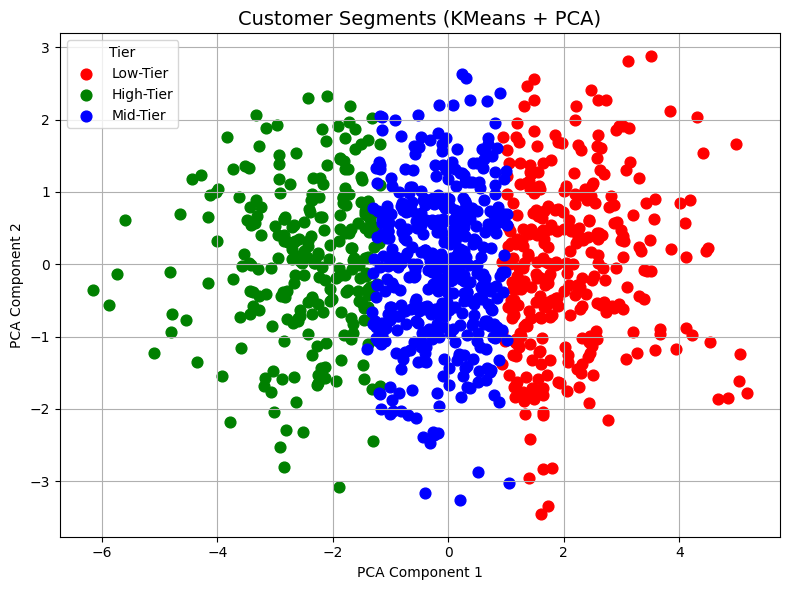

In [29]:
#Kmeans,Dimensional reduction,pipeline , extract the required data (PCA values,Tier),Calculating The stats based on tier , visualisation

# 6. Pipeline
pipeline = Pipeline(stages=[assembler, scaler, kmeans, pca])

# 7. model training
model = pipeline.fit(customer_df)
result = model.transform(customer_df)


# Extract PCA columns
extract_pca1 = udf(lambda v: float(v[0]), FloatType())
extract_pca2 = udf(lambda v: float(v[1]), FloatType())
result = result.withColumn("PCA1", extract_pca1("pca_features")) \
               .withColumn("PCA2", extract_pca2("pca_features"))

result.show()
#  Map Clusters to Tiers (based on TotalSpend)
tier_means = result.groupBy("Cluster").agg(avg("TotalSpend").alias("avg_spend")) \
                   .orderBy("avg_spend").rdd.map(lambda row: row["Cluster"]).collect()

tier_names = ["Low-Tier", "Mid-Tier", "High-Tier"]
tier_dict = dict(zip(tier_means, tier_names))

# Broadcast tier map
from pyspark.sql.functions import create_map, lit
from itertools import chain

tier_map_expr = create_map([lit(x) for x in chain(*tier_dict.items())])
result = result.withColumn("Tier", tier_map_expr[col("Cluster")])

# Save Summary
summary = result.groupBy("Tier").agg(
    *[avg(col).alias(col + "_mean") for col in features]
)

import matplotlib.pyplot as plt

# Collect only necessary columns for plotting
plot_df = result.select("PCA1", "PCA2", "Tier").toPandas()

# Assign a color to each tier
color_map = {"Low-Tier": "red", "Mid-Tier": "blue", "High-Tier": "green"}

plt.figure(figsize=(8, 6))
for tier in plot_df["Tier"].unique():
    subset = plot_df[plot_df["Tier"] == tier]
    plt.scatter(subset["PCA1"], subset["PCA2"], color=color_map[tier], label=tier, s=60)

plt.title("Customer Segments (KMeans + PCA)", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Tier")
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
# 8. Evaluation
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(
    featuresCol="features",
    predictionCol="Cluster",
    metricName="silhouette",
    distanceMeasure="squaredEuclidean"
)

score = evaluator.evaluate(result)
print(f" Silhouette Score: {score}")
-

 Silhouette Score: 0.3657092241635684


In [25]:
# 9. Register the result DataFrame as a temporary view
result.createOrReplaceTempView("customer_clusters")

sql_avg = spark.sql("""
SELECT Cluster, Tier,
       ROUND(AVG(TotalSpend), 2) AS AvgSpend,
       ROUND(AVG(ActiveDays), 2) AS AvgActiveDays,
       COUNT(*) AS CustomerCount
FROM customer_clusters
GROUP BY Cluster, Tier
ORDER BY AvgSpend DESC
""")

sql_avg.show()

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def purchase_level(qty):
    if qty >= 2500:
        return "Heavy Buyer"
    elif qty >= 1500:
        return "Moderate Buyer"
    else:
        return "Light Buyer"

purchase_udf = udf(purchase_level, StringType())
result = result.withColumn("PurchaseLevel", purchase_udf("Quantity_sum"))

result.select("CustomerID", "Quantity_sum", "PurchaseLevel").show(5)

spark.udf.register("purchase_level", purchase_level,StringType())

# SQL version
spark.sql("""
SELECT CustomerID, Quantity_sum, purchase_level(Quantity_sum) AS PurchaseLevel
FROM customer_clusters
LIMIT 5
""").show()


+-------+---------+---------+-------------+-------------+
|Cluster|     Tier| AvgSpend|AvgActiveDays|CustomerCount|
+-------+---------+---------+-------------+-------------+
|      2|High-Tier|131139.36|       360.11|          249|
|      0| Mid-Tier|114368.33|       359.54|          430|
|      1| Low-Tier| 98158.84|       356.91|          321|
+-------+---------+---------+-------------+-------------+

+----------+------------+--------------+
|CustomerID|Quantity_sum| PurchaseLevel|
+----------+------------+--------------+
|     10206|        1963|Moderate Buyer|
|     10362|        1899|Moderate Buyer|
|     10623|        2945|   Heavy Buyer|
|     10817|        2021|Moderate Buyer|
|     10081|        2049|Moderate Buyer|
+----------+------------+--------------+
only showing top 5 rows

+----------+------------+--------------+
|CustomerID|Quantity_sum| PurchaseLevel|
+----------+------------+--------------+
|     10206|        1963|Moderate Buyer|
|     10362|        1899|Moderate B

In [26]:
# Save result as CSV
result.select("CustomerID", "InvoiceNo_nunique", "Quantity_sum", "UnitPrice_mean",
              "StockCode_nunique", "TotalSpend", "ActiveDays", "PCA1", "PCA2", "Tier") \
      .coalesce(1) \
      .write \
      .mode("overwrite") \
      .option("header", True) \
      .csv("customer_with_tier")
print("✅ Saved: 'customer_with_tier' (as CSV folder)")


summary.coalesce(1).write.mode("overwrite").option("header", True).csv("customer_tier_summary")
print("✅ Saved: 'customer_tier_summary' (as CSV folder)")


✅ Saved: 'customer_with_tier' (as CSV folder)
✅ Saved: 'customer_tier_summary' (as CSV folder)


In [47]:

sample_data = spark.createDataFrame([
    (99999, 15, 1-500, 1, 120, 2600.0, 40)
], ["CustomerID", "InvoiceNo_nunique", "Quantity_sum", "UnitPrice_mean", "StockCode_nunique", "TotalSpend", "ActiveDays"])


predicted_sample = model.transform(sample_data)
predicted_sample = predicted_sample.withColumn("PCA1", extract_pca1("pca_features")) \
                                   .withColumn("PCA2", extract_pca2("pca_features"))
predicted_sample = predicted_sample.withColumn("Tier", tier_map_expr[col("Cluster")])
predicted_sample = predicted_sample.withColumn("PurchaseLevel", purchase_udf("Quantity_sum"))

predicted_sample.select(
    "CustomerID", "Cluster", "PCA1", "PCA2", "PurchaseLevel"
).show(truncate=False)


+----------+-------+---------+----------+--------------+
|CustomerID|Cluster|PCA1     |PCA2      |PurchaseLevel |
+----------+-------+---------+----------+--------------+
|99999     |1      |14.693917|-0.9030193|Moderate Buyer|
+----------+-------+---------+----------+--------------+



In [ ]:
from google.colab import files
files.download('/content/customer_tier_summary/part-00000-cbe567ac-4c9b-4458-870a-587aed84c4a1-c000.csv')
files.download('/content/customer_with_tier/part-00000-b8238018-ba3a-47f8-a41b-f62fe59d4f9b-c000.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>